In [20]:
import sys,os
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import plotting
import pandas as pd
from root_pandas import read_root, to_root
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ks_2samp
import xgboost as xgb

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [21]:
#Load signal with all the BDTs applied
BDT_str = "all_BDT"
path = f"{loc.OUT}/ROOT"
df_sig = read_root(f"{path}/Bc2TauNu_{BDT_str}.root","events",columns=["BDT_all"])

df_Bu = read_root(f"{path}/Bu2TauNu_{BDT_str}.root","events",columns=["BDT_all"])

In [22]:
#Load backgrounds with all BDTs applied
df_bkg = {}
for q in ["uds","cc","bb"]:
    df_bkg[q] = read_root(f"{path}/inclusive_Z{q}_{BDT_str}.root","events",columns=["BDT_all"])
    print(len(df_bkg[q]))

9980004
4655078
9882716


In [26]:
#Get maximum BDT scores for each background type
BDT_high = {}
for q in ["uds","cc","bb"]:
    BDT_high[q] = df_bkg[q]["BDT_all"].max()
print(BDT_high)
#Find highest of these
max_BDT = 0.
for q in ["uds","cc","bb"]:
    if(BDT_high[q] > max_BDT):
        max_BDT = BDT_high[q]
print(max_BDT)

{'uds': 0.995956689119339, 'cc': 0.9963912963867188, 'bb': 0.9970511198043823}
0.9970511198043823


In [32]:
#Cut on the maximum BDT score, which rejects all of the background in each sample i.e. 10^6 rejection of qq, cc, and bb
n_sig_tot = float(len(df_sig))
n_sig_pass = float(len(df_sig.query(f"BDT_all > {max_BDT}")))
eff_sig = n_sig_pass / n_sig_tot
print("Signal efficiency for BDT cut that rejects 10^7 of all three backgrounds: %.3f" % eff_sig)

n_Bu_tot = float(len(df_Bu))
n_Bu_pass = float(len(df_Bu.query(f"BDT_all > {max_BDT}")))
eff_Bu = n_Bu_pass / n_Bu_tot
print("B+ -> tau nu efficiency for BDT cut that rejects 10^7 of all three backgrounds: %.3f" % eff_Bu)

Signal efficiency for BDT cut that rejects 10^7 of all three backgrounds: 0.601
B+ -> tau nu efficiency for BDT cut that rejects 10^7 of all three backgrounds: 0.000


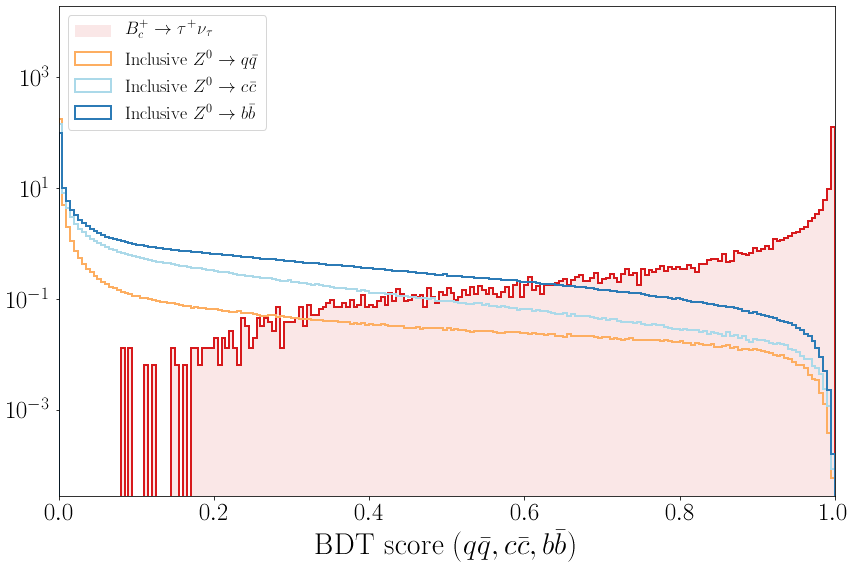

In [33]:
#Plot the BDT distribution in each of the samples
mode_config = {"sig": ["$B_c^+ \\to \\tau^+ \\nu_\\tau$","#d7191c"],
               "Bu": ["$B^+ \\to \\tau^+ \\nu_\\tau$","#313695"],
               "uds": ["q\\bar{q}","#fdae61"],
               "cc": ["c\\bar{c}","#abd9e9"],
               "bb": ["b\\bar{b}","#2c7bb6"]
              }
bins = 200
BDT_range = (0,1)
fig, ax = plt.subplots(figsize=(12,8))
plt.hist(df_sig["BDT_all"],bins=bins,color=mode_config["sig"][1],range=BDT_range,histtype='step',density=True,linewidth=2,label="")
plt.hist(df_sig["BDT_all"],bins=bins,color=mode_config["sig"][1],range=BDT_range,histtype='stepfilled',density=True,alpha=0.1,label=mode_config["sig"][0])
#plt.hist(df_Bu["BDT_all"],bins=bins,color=mode_config["Bu"][1],range=BDT_range,histtype='step',density=True,linewidth=2,label=mode_config["Bu"][0])
for q in ["uds","cc","bb"]:
    plt.hist(df_bkg[q]["BDT_all"],bins=bins,color=mode_config[q][1],range=BDT_range,histtype='step',density=True,linewidth=2,label="Inclusive $Z^0 \\to %s$" % mode_config[q][0])
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,1)
plt.xlabel("BDT score ($q\\bar{q},c\\bar{c},b\\bar{b}$)",fontsize=30)
plt.yscale('log')
ymin,ymax = plt.ylim()
plt.ylim(ymin,50*ymax)
plt.legend(fontsize=18, loc="upper left")
plt.tight_layout()
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_vs_inclusive_Zqq_BDT.pdf")